In [1]:
##Con matriz de confusion

# Se importan todas las librerías que vamos a necesitar
##'''Importing Libraries'''
import pandas as pd
import nltk
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score
from nltk.corpus import stopwords
import preprocessor as p
from keras.preprocessing.text import text_to_word_sequence   ##NEW
from nltk.stem import WordNetLemmatizer                      ##NEW
from pywsd.utils import lemmatize_sentence
from sklearn import svm
import emoji                                                 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


Using TensorFlow backend.
Warming up PyWSD (takes ~10 secs)... took 11.395667552947998 secs.


In [2]:
# Se importa el dataset y lo guardamos en 'data'. Se guardan solamente el texto de los tweets en 'tweets'
##data= pd.read_csv('Downloads/Tweets.csv')
data= pd.read_csv('Tweets.csv')
tweets = data['text']
tweets.head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

In [3]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# Se cambian las variables categóricas de la columna airline_sentiment a variables numéricas: 
## Negative : 0
## Neutral : 1
## Positive : 2

from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
data['target'] = lb.fit_transform(data['airline_sentiment'])
data[['airline_sentiment', 'target']]
target = data['target']
print(data[['airline_sentiment', 'target']])

      airline_sentiment  target
0               neutral       1
1              positive       2
2               neutral       1
3              negative       0
4              negative       0
5              negative       0
6              positive       2
7               neutral       1
8              positive       2
9              positive       2
10              neutral       1
11             positive       2
12             positive       2
13             positive       2
14             positive       2
15             negative       0
16             positive       2
17             negative       0
18             positive       2
19             positive       2
20             negative       0
21             positive       2
22             positive       2
23              neutral       1
24             negative       0
25             negative       0
26             negative       0
27              neutral       1
28             negative       0
29              neutral       1
...     

In [5]:
# Se comprueba la correlación entre el tweet (text) y su etiqueta
df = data[['text', 'target']]
df.sample(4)

,text,target
3650,@united Apologize to the President. Once those...,0
7801,@JetBlue it was but obviously it wasn't linked...,0
7577,@JetBlue she waved someone behind me to step f...,0
417,@VirginAmerica how come you don't have an iPho...,0


In [6]:
# Se comprueba que el campo de tweets y el campo de target tiene la misma longitud.
print('Número de tweets: ' + ' ' + str(len(tweets)),'\nNúmero de targets:' + ' ' + str(len(target)))

Número de tweets:  14640 
Número de targets: 14640


In [7]:
# Se comprueba que codifica correctamente
# Al final de la tabla se observa la nueva variable (target)
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,target
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),1
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),2
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),1
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),0
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),0


In [8]:
# Se preprocesan los tweets con tweet-preprocessor5.0 y se eliminan solamente las menciones y los hashtags.
# Se guardan los tweets en un lista, la cual contiene todos los tweets sin hashtags ni menciones.
##'''Preprocessing : tweet preprocessor 5.0'''
tweets_preprocessed = []
for tweet in tweets:
    p.set_options(p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.URL)
    tweets_preprocessed.append(p.clean(tweet))
    

In [9]:
tweets_preprocessed

['What said.',
 "plus you've added commercials to the experience... tacky.",
 "I didn't today... Must mean I need to take another trip!",
 'it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 "and it's a really big bad thing about it",
 "seriously would pay $30 a flight for seats that didn't have this playing. it's really the only bad thing about flying VA",
 'yes, nearly every time I fly VX this “ear worm” won’t go away :)',
 'Really missed a prime opportunity for Men Without Hats parody, there.',
 "Well, I didn't…but NOW I DO! :-D",
 "it was amazing, and arrived an hour early. You're too good to me.",
 'did you know that suicide is the second leading cause of death among teens 10-24',
 'I &lt;3 pretty graphics. so much better than minimal iconography. :D',
 "This is such a great deal! Already thinking about my 2nd trip to &amp; I haven't even gone on my 1st trip yet! ;p",
 "I'm flying your skies again! U take all the aw

In [10]:
tweets_cleaned_0= []  

##for tweet in tweets:
for tweet in tweets_preprocessed:   
   # tweet = re.sub(r'(?:@[\w_]+)', " ", tweet) # @-mentions
   # tweet = re.sub(r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", " ", tweet) # hash-tags
    tweet = emoji.demojize(tweet).replace('_','')
   #text = re.sub(r'\d+', '', text)
    tweet = re.sub(r'\b\w{1,1}\b', '', tweet)
   #text = re.sub(r'http.?://[^\s]+[\s]?', '', text) #Remove URLs
    #return text
    tweets_cleaned_0.append(tweet) 
##test_str = clean_text(test_str)
##tweets_preprocessed = clean_text(test_str)

In [11]:
tweets_cleaned_0

['What said.',
 "plus you've added commercials to the experience... tacky.",
 " didn' today... Must mean  need to take another trip!",
 'it\' really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 "and it'  really big bad thing about it",
 "seriously would pay $30  flight for seats that didn' have this playing. it' really the only bad thing about flying VA",
 'yes, nearly every time  fly VX this “ear worm” won’ go away :)',
 'Really missed  prime opportunity for Men Without Hats parody, there.',
 "Well,  didn'…but NOW  DO! :-",
 "it was amazing, and arrived an hour early. You're too good to me.",
 'did you know that suicide is the second leading cause of death among teens 10-24',
 ' &lt; pretty graphics. so much better than minimal iconography. :',
 "This is such  great deal! Already thinking about my 2nd trip to &amp;  haven' even gone on my 1st trip yet! ;",
 "' flying your skies again!  take all the away from travel",
 'Thanks!

In [12]:
###OLD..MARTA
# (MARTA !!!! ) Meter más contracciones: https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
'''Preprocessing'''
tweets_cleaned_1=[]
for s in range(len(tweets_cleaned_0)):
    tweet = re.sub(r"that's","that is", str(tweets_cleaned_0[s]))
    tweet = re.sub(r"there's","there is",tweet)
    tweet = re.sub(r"you've","you have",tweet)
    tweet = re.sub(r"I've","I have",tweet)
    tweet = re.sub(r"they've","they have",tweet)
    tweet = re.sub(r"we've","we have",tweet)
    tweet = re.sub(r"there're","there are",tweet)
    tweet = re.sub(r"what's","what is",tweet)
    tweet = re.sub(r"where's","where is",tweet)
    tweet = re.sub(r"it's","it is",tweet)
    tweet = re.sub(r"who's","who is",tweet)
    tweet = re.sub(r"i'm","i am",tweet)
    tweet = re.sub(r"they're","they are",tweet)
    tweet = re.sub(r"she's","she is",tweet)
    tweet = re.sub(r"he's","he is",tweet)
    tweet = re.sub(r"it's","it is",tweet)
    tweet = re.sub(r"they're","they are",tweet)
    tweet = re.sub(r"who're","who are",tweet)
    tweet = re.sub(r"ain't","am not",tweet)
    tweet = re.sub(r"wouldn't","would not",tweet)
    tweet = re.sub(r"shouldn't","should not",tweet)
    tweet = re.sub(r"can't","can not",tweet)
    tweet = re.sub(r"couldn't","could not",tweet)
    tweet = re.sub(r"we'll","we will",tweet)
    tweet = re.sub(r"I'll","I will",tweet)
    tweet = re.sub(r"you'll","you will",tweet)
    tweet = re.sub(r"she'll","she will",tweet)
    tweet = re.sub(r"he'll","he will",tweet)
    tweet = re.sub(r"it'll","it will",tweet)
    tweet = re.sub(r"won't","will not",tweet)
    tweet = re.sub(r"could've","could have",tweet)
    tweet = re.sub(r"couldn't've","could not have",tweet)
    tweet = re.sub(r"didn't","did not",tweet)
    tweet = re.sub(r"don't","do not",tweet)
    tweet = re.sub(r"doesn't","does not",tweet)
    tweet = re.sub(r"everyone's","everyone is",tweet)
    tweet = re.sub(r"giv’n","given",tweet)
    tweet = re.sub(r"hasn't","has not",tweet)
    tweet = re.sub(r"haven't","have not",tweet)
    tweet = re.sub(r"hadn't","had not",tweet)
    tweet = re.sub(r"who're","who are",tweet)
    ##PDTE TRATAR SIGNOS DE PUNTUACION DE EMOTICONOS!!!
    #tweet = re.sub(r':', ' ', tweet) QUITAR EN LAVERSION DEFINITIVA
    tweet = re.sub(r'\W', ' ', tweet)  ##quita signos de puntuación
    tweet = re.sub(r'\d', ' ', tweet)
    tweet = tweet.lower()
    tweet = re.sub(r'^br$', ' ', tweet)
    tweet = re.sub(r'^[a-zA-Z]\s', ' ', tweet)
    tweet = re.sub(r'\s+br\s+',' ',tweet)
    tweet = re.sub(r'\s+[a-z]\s+', ' ',tweet)
    tweet = re.sub(r'^b\s+', '', tweet)
    tweet = re.sub(r'\s+', ' ', tweet)
    tweet = tweet.split()
    tweet = ' '.join(tweet)
    tweets_cleaned_1.append(tweet) 

In [13]:
tweets_cleaned_1

['what said',
 'plus you have added commercials to the experience tacky',
 'didn today must mean need to take another trip',
 'it really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse',
 'and it really big bad thing about it',
 'seriously would pay flight for seats that didn have this playing it really the only bad thing about flying va',
 'yes nearly every time fly vx this ear worm won go away',
 'really missed prime opportunity for men without hats parody there',
 'well didn but now do',
 'it was amazing and arrived an hour early you re too good to me',
 'did you know that suicide is the second leading cause of death among teens',
 'lt pretty graphics so much better than minimal iconography',
 'this is such great deal already thinking about my nd trip to amp haven even gone on my st trip yet',
 'flying your skies again take all the away from travel',
 'thanks',
 'sfo pdx schedule is still mia',
 'so excited for my first cross country fl

In [14]:
tweets_cleaned_0

['What said.',
 "plus you've added commercials to the experience... tacky.",
 " didn' today... Must mean  need to take another trip!",
 'it\' really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 "and it'  really big bad thing about it",
 "seriously would pay $30  flight for seats that didn' have this playing. it' really the only bad thing about flying VA",
 'yes, nearly every time  fly VX this “ear worm” won’ go away :)',
 'Really missed  prime opportunity for Men Without Hats parody, there.',
 "Well,  didn'…but NOW  DO! :-",
 "it was amazing, and arrived an hour early. You're too good to me.",
 'did you know that suicide is the second leading cause of death among teens 10-24',
 ' &lt; pretty graphics. so much better than minimal iconography. :',
 "This is such  great deal! Already thinking about my 2nd trip to &amp;  haven' even gone on my 1st trip yet! ;",
 "' flying your skies again!  take all the away from travel",
 'Thanks!

In [15]:
tweets_cleaned_2=[]

for sentence in tweets_cleaned_1:
    lem = lemmatize_sentence(sentence)
    lem = ' '.join(lem)
    tweets_cleaned_2.append(lem)

In [95]:
tweets_cleaned_2

['what say',
 'plus you have add commercial to the experience tacky',
 'didn today must mean need to take another trip',
 'it really aggressive to blast obnoxious entertainment in your guest face amp they have little recourse',
 'and it really big bad thing about it',
 'seriously would pay flight for seat that didn have this playing it really the only bad thing about fly va',
 'yes nearly every time fly vx this ear worm win go away',
 'really missed prime opportunity for men without hat parody there',
 'well didn but now do',
 'it be amaze and arrive an hour early you re too good to me',
 'do you know that suicide be the second leading cause of death among teen',
 'lt pretty graphic so much good than minimal iconography',
 'this be such great deal already think about my nd trip to amp haven even go on my st trip yet',
 'fly your sky again take all the away from travel',
 'thanks',
 'sfo pdx schedule be still mia',
 'so excited for my first cross country flight lax to mco ve heard nothi

In [96]:
tweets_cleaned_1

['what said',
 'plus you have added commercials to the experience tacky',
 'didn today must mean need to take another trip',
 'it really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse',
 'and it really big bad thing about it',
 'seriously would pay flight for seats that didn have this playing it really the only bad thing about flying va',
 'yes nearly every time fly vx this ear worm won go away',
 'really missed prime opportunity for men without hats parody there',
 'well didn but now do',
 'it was amazing and arrived an hour early you re too good to me',
 'did you know that suicide is the second leading cause of death among teens',
 'lt pretty graphics so much better than minimal iconography',
 'this is such great deal already thinking about my nd trip to amp haven even gone on my st trip yet',
 'flying your skies again take all the away from travel',
 'thanks',
 'sfo pdx schedule is still mia',
 'so excited for my first cross country fl

In [97]:
d = {'target': target, 'tweet': tweets_cleaned_2}
target_tweet = pd.DataFrame(data=d)

In [98]:
target_tweet

,target,tweet
0,1,what say
1,2,plus you have add commercial to the experience...
2,1,didn today must mean need to take another trip
3,0,it really aggressive to blast obnoxious entert...
4,0,and it really big bad thing about it
5,0,seriously would pay flight for seat that didn ...
6,2,yes nearly every time fly vx this ear worm win...
7,1,really missed prime opportunity for men withou...
8,2,well didn but now do
9,2,it be amaze and arrive an hour early you re to...


In [16]:
y=data['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(tweets_cleaned_2, y, train_size=0.8, random_state=0)
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 4,
                             max_df = 0.9,
                             sublinear_tf = True,
                             use_idf = True)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [54]:
#Logistic Regression
classifier_lr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial') 
classifier_lr.fit(train_vectors, y_train)
prediction_lr = classifier_lr.predict(test_vectors)

In [55]:
print(confusion_matrix(y_test,prediction_lr))  
print(classification_report(y_test, prediction_lr))  
print(accuracy_score(y_test, prediction_lr))

[[1734  104   32]
 [ 237  338   39]
 [ 121   52  271]]
             precision    recall  f1-score   support

   negative       0.83      0.93      0.88      1870
    neutral       0.68      0.55      0.61       614
   positive       0.79      0.61      0.69       444

avg / total       0.79      0.80      0.79      2928

0.8002049180327869


In [63]:
#SVM
classifier_svm = svm.SVC(kernel='linear', gamma='auto', decision_function_shape='ovo')
classifier_svm.fit(train_vectors, y_train)
prediction_svm = classifier_svm.predict(test_vectors)

In [64]:
print(confusion_matrix(y_test,prediction_svm))  
print(classification_report(y_test, prediction_svm))  
print(accuracy_score(y_test, prediction_svm))

[[1715  116   39]
 [ 233  342   39]
 [ 103   52  289]]
             precision    recall  f1-score   support

   negative       0.84      0.92      0.87      1870
    neutral       0.67      0.56      0.61       614
   positive       0.79      0.65      0.71       444

avg / total       0.79      0.80      0.79      2928

0.8012295081967213


<IPython.core.display.Javascript object>


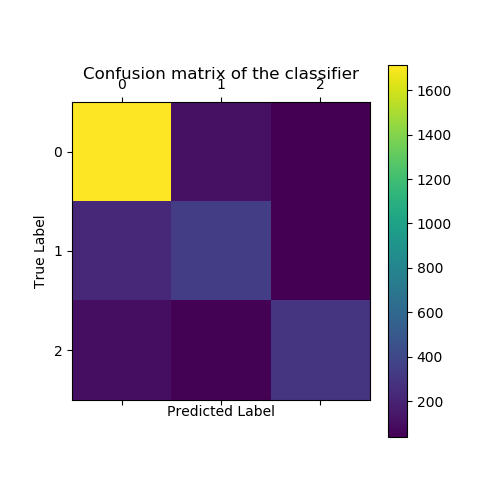

In [70]:
from sklearn.metrics import confusion_matrix
import pylab as pl

cm = confusion_matrix(y_test,prediction_svm)
pl.matshow(cm)
pl.title('Confusion matrix of the classifier - SVM')
pl.xlabel('Predicted Label')
pl.ylabel('True Label')
pl.colorbar()
pl.show()

In [21]:
''' Training the classifier : RandomForestClassifier'''
# Training the classifier 
classifier_rf = RandomForestClassifier(n_estimators=1000, random_state=0)  
classifier_rf.fit(train_vectors, y_train) 
# Testing model performance
y_pred_rf=classifier_rf.predict(test_vectors)

In [22]:
'''Evaluating the Model - Random Forest'''
#RandomForestClassifier
print(confusion_matrix(y_test,y_pred_rf))  
print(classification_report(y_test,y_pred_rf))  
print(accuracy_score(y_test, y_pred_rf))

[[1774   74   22]
 [ 348  237   29]
 [ 199   45  200]]
             precision    recall  f1-score   support

   negative       0.76      0.95      0.85      1870
    neutral       0.67      0.39      0.49       614
   positive       0.80      0.45      0.58       444

avg / total       0.75      0.76      0.73      2928

0.7551229508196722


In [26]:
''' Training the classifier : DecisionTreeClassifier'''
# Training the classifier 
classifier_dt = DecisionTreeClassifier(criterion='gini')  
classifier_dt.fit(train_vectors, y_train) 
# Testing model performance
y_pred_dt=classifier_dt.predict(test_vectors)

In [27]:
'''Evaluating the Model'''
#DecisionTreeClassifier
print(confusion_matrix(y_test,y_pred_dt))  
print(classification_report(y_test,y_pred_dt))  
print(accuracy_score(y_test, y_pred_dt))

[[1480  264  126]
 [ 265  271   78]
 [ 129   80  235]]
             precision    recall  f1-score   support

   negative       0.79      0.79      0.79      1870
    neutral       0.44      0.44      0.44       614
   positive       0.54      0.53      0.53       444

avg / total       0.68      0.68      0.68      2928

0.6782786885245902


Confusion Matrix (no-normalized)
[[1715  116   39]
 [ 233  342   39]
 [ 103   52  289]]
Confusion Matrix (normalized)
[[0.92 0.06 0.02]
 [0.38 0.56 0.06]
 [0.23 0.12 0.65]]


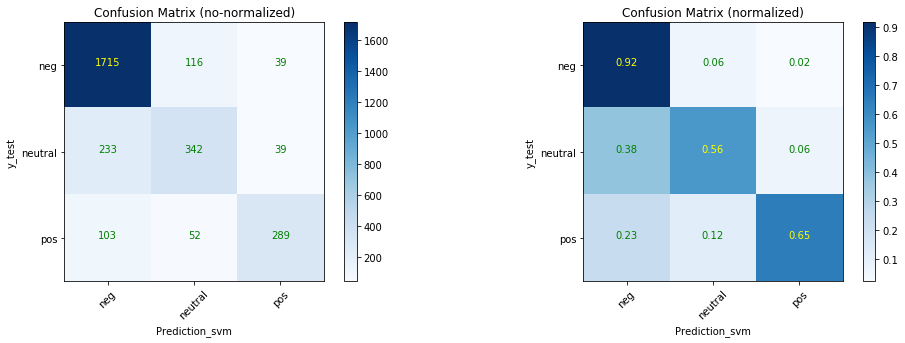

In [124]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion Matrix (normalized)")
    else:
        print('Confusion Matrix (no-normalized)')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="yellow" if cm[i, j] > thresh else "green")

    plt.ylabel('y_test')
    plt.xlabel('Prediction_svm')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, prediction_svm)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 10))
plt.subplot(221)
plot_confusion_matrix(cnf_matrix, classes=['neg', 'neutral', 'pos'],
                      title='Confusion Matrix (no-normalized)')
plt.subplot(222)
plot_confusion_matrix(cnf_matrix, classes=['neg', 'neutral', 'pos'],
                      normalize = True,
                      title='Confusion Matrix (normalized)')

plt.subplots_adjust(top=1, bottom=0.1, left=0.1, right=0.95, hspace=0.5,
                    wspace=0.3)

plt.show()

Confusion Matrix (no-normalized)
[[1734  104   32]
 [ 237  338   39]
 [ 121   52  271]]
Confusion Matrix (normalized)
[[0.93 0.06 0.02]
 [0.39 0.55 0.06]
 [0.27 0.12 0.61]]


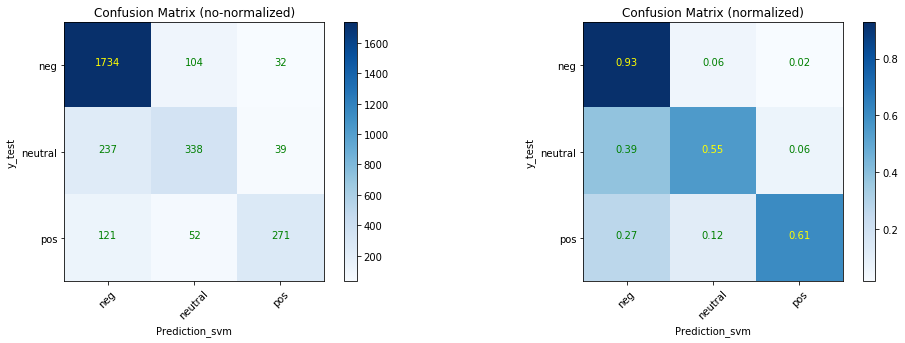

In [125]:
# Plot --> Confusion Matrix: Logistic Regression
cnf_matrix_lr = confusion_matrix(y_test, prediction_lr)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 10))
plt.subplot(221)
plot_confusion_matrix(cnf_matrix_lr, classes=['neg', 'neutral', 'pos'],
                      title='Confusion Matrix (no-normalized)')
plt.subplot(222)
plot_confusion_matrix(cnf_matrix_lr, classes=['neg', 'neutral', 'pos'],
                      normalize = True,
                      title='Confusion Matrix (normalized)')

plt.subplots_adjust(top=1, bottom=0.1, left=0.1, right=0.95, hspace=0.5,
                    wspace=0.3)

plt.show()